## Procrustes analysis: Comparing community and AMR gene abundances across farm cohort
This notebook is tracking my data exploration steps to assess how profile antimicrobial resistance (AMR) gene abundances and community structure in stored dairy manure are related across a cohort of dairy farms. 

My aims are to perform Procrustes analysis on reduced count data. Here I explore different data reduction tools to evaluate the robustness of the results to the different assumptions embedded in data reduction and build a data-visualization tool.

Once the methods are ironed out, I will convert the code chunks into user-friendly command line tools to facilitate reproduciblity of the workflow. 

This work was advised in part by Kerby Shedden, Phd. (UM Dept. of Statistics)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import procrustes, distance
from scipy import stats
from sklearn.decomposition import PCA
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from sklearn import manifold
import matplotlib.patches as mpatches

# In-house Python scripts
from summarize_taxa import summarize_taxa
from MDS_hellinger import perform_mds

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### Load and summarize phyloflash results at different taxon levels
This analysis starts with raw count data from programs that assign metagenomic reads to sequences to predict the species and resistance gene compositions. The outputs from each sample were concatonated with a script in my utils folder.

In [2]:
# Set file paths to relevant data
amrplus = "Final_AMR-NTU_Data/AMRplusplus_raw.tsv"
phylo = "Final_AMR-NTU_Data/phylo2020.tsv"

# Metadata I curated by hand in Microsoft Excel
meta = "transposed.tsv"

In [3]:
# Load the relevant datasets
amrplus_raw = pd.read_csv(amrplus, delimiter="\t")
phylo_raw = pd.read_csv(phylo, delimiter="\t")
meta_data = pd.read_csv(meta, delimiter="\t")
meta_data = meta_data.set_index("meta")

In [4]:
# Summarize at the OTUs Family-level to reduce species-level noise
taxa_column = ['domain','phylum','class','order','family','genus','species']
delimeter = ";"
df = phylo_raw
taxa_level = 5 #family-level
taxa_header = 'OTU'
count_header = 'est_counts'

phylo_fam = summarize_taxa(df, count_header, taxa_header, taxa_column, delimeter, taxa_level)

### Automate as python script
Clearly, the next couple steps could be automated into a python script to faciliate switching imput data and observing the outomces of procrustes. Given parameters would be the headers of the data matrix. Then the user can just run the data reduction on with a command like `perform_mds(dr_formatted(df))` where df_formated is the combined steps of pivoting data to wide form and taking the given transformation.

#### Psuedocode:

dr_formatted(df, headers, transform)

"""
    Pre-processing raw count data for dimensional reduction

    Args:
    df        : long form dataset of samples from program like phyloflash or GROOT
    headers   : list of strings containing column headers
    transform : log or square root

    Returns:
    df_DR : dataframe ready for dimensional reduction
    
    Psuedocode:
    
    pd.pivot(df, columns, index, values)
    """

In [5]:
# Make the data wide-form
OTU_rw = pd.pivot(phylo_fam, columns="sid", index="OTU", values="est_counts")
AMR_rw = pd.pivot(amrplus_raw, columns="sid", index="AMR", values="est_counts")
# AMR_rw = pd.pivot(amrplus_raw[['OTU', 'sid', 'est_counts']], columns="sid", index="OTU", values="est_counts")

### Procrustes Analysis
Currently I am comparing how similar the OTU (family level) and ARG (AMR++, MEGARes Lab) relative abundances compare across samples. To ensure this approach in meaningful, I am taking a step back, thinking about our abundance estimates, and reviewing different dimensional reduction techniques. I will stick to looking at relative abundances. Other scaling techniques can introduce bias. We are interested if the *composition* of the communities and ARGs have similar patterns across farms and AD/non-AD groups. 

**Aims:**
1. Perform analysis using different taxonomic level summaries of community structure
2. Compare different DR techniques \
    a. Bray-Curtis MDS \
    b. Jaccard Distance MDS \
    c. Pairwise-Hellinger distance MDS \
    d. PCA

In [6]:
## This script was modified from an alignment-based hamming distance tool from Bioinf 529.

def build_distance_matrix(df, dist_metric): 
    ''' Function to build a distance matrix from a matrix of counts
    
    Args: 
        df       : numeric array of count data. 
                   Columns are samples and rows are different organisms or genes
        distance : metric to use (bray-curtis, hellinger, jaccard)

    Returns:
        distance_matrix (np.array of floats): n x n distance matrix
    
    '''
         
    n = df.shape[1]
    
    #Initialize an empty matrix of floats
    distance_matrix = np.zeros((n, n), dtype=float)
    
    #Compare all of the alignments and store their distances
    if dist_metric == "BC":
        for i, sample1 in enumerate(df.columns):
            for j, sample2 in enumerate(df.columns):
                distance_matrix[i][j] = distance.braycurtis(df[sample1], df[sample2])
    
    #Compare all of the alignments and store their distances
    if dist_metric == "J":
        for i, sample1 in enumerate(df.columns):
            for j, sample2 in enumerate(df.columns):
                distance_matrix[i][j] = distance.jaccard(df[sample1], df[sample2])   

    # Pairwise Hellinger distances
    if dist_metric == "PH": 
        
        # Convert to relative abundance
        df = df.transpose()
        tot = df.sum(1)
        df = df.divide(tot, axis=0)

        # Sort the columns in descending abundance order
        ii = np.argsort(df.sum(0))
        df = df.iloc[:, ii[::-1]]
        dq = np.sqrt(np.asarray(df))
        for i in range(n):
            for j in range(i):
                d = np.sum((dq[i, :] - dq[j, :])**2)
                d = np.sqrt(d) / np.sqrt(2)
                distance_matrix[i, j] = d
                distance_matrix[j, i] = d
        distance_matrix = pd.DataFrame(distance_matrix)
    
    return distance_matrix

In [7]:
# MDS with specified distance metric
metric = "BC"

OTU_bc = build_distance_matrix(np.sqrt(OTU_rw.fillna(0)), metric)
AMR_bc = build_distance_matrix(np.sqrt(AMR_rw.fillna(0)), metric)

mds = manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=1000)
pos_otu = mds.fit(OTU_bc).embedding_
pos_amr = mds.fit(AMR_bc).embedding_

pos_otu

mtx1, mtx2, disparity = procrustes(pos_otu,pos_amr)
disparity

0.3610111233006573

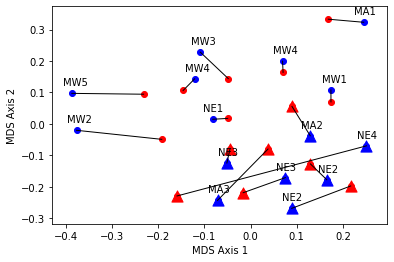

In [8]:
# Need to turn this into a function to run after dimensional Reduction
otu_pts = pd.DataFrame(mtx1,columns=["x","y"])
amr_pts = pd.DataFrame(mtx2,columns=["x","y"])

otu_pts['source'] = 'OTU'
amr_pts['source'] = 'ARG'

# If statement with AD to plot shape too
plt.scatter(x=otu_pts['x'], y=otu_pts['y'], color = "blue", label = "Storage only, OTUs")
plt.scatter(x=amr_pts['x'], y=amr_pts['y'], color = "red", label = "Storage only, AMR Genes")

sid_list14 = ["MW1","MW2",'MW3',"MW4","MW4","MA1","NE1","NE2","NE2","NE3","NE3","NE4","MA2","MA3","MW5"]

for i in range(len(otu_pts)):
    plt.plot([otu_pts['x'][i], amr_pts['x'][i]], [otu_pts['y'][i], amr_pts['y'][i]], 'k-', lw=1)
    # can add an if statement (if y_otu > y_amr, plot above or below the given coordinate)
    plt.text(otu_pts['x'][i]-0.02, otu_pts['y'][i] + 0.025, sid_list14[i])
    
    if int(meta_data.iloc[0,][i]) == 0:
        plt.scatter(otu_pts['x'][i], otu_pts['y'][i], marker='^', s = 125, c = "blue", label = "AD Farm, OTUs")
        plt.scatter(amr_pts['x'][i], amr_pts['y'][i], marker='^', s = 125, c = "red", label = "AD Farm, AMR Genes")

plt.xlabel("MDS Axis 1")
plt.ylabel("MDS Axis 2")

red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')

# Currently struggling with effective way to let matplot lib build legend
# plt.legend()
# plt.legend([red_patch, blue_patch, triangle], ['AMR gene Composition', 'OTU Composition', "AD"])

# plt.savefig("2020-09_procrustes.png", dpi=100, bbox_inches='tight', pad_inches=0.5)

## _Scratch work below_

In [47]:
# for i in range(len(otu_pts)):
#     if int(meta_data.iloc[0,][i]) == 0:
#         print(sid_list14[i],"has AD")

area = (30 * np.random.rand(5))**2 
area
# int(meta_data.iloc[0,][4])

array([114.0722698 , 128.60218011, 847.22604802, 378.98616618,
       768.84038564])

In [ ]:
# Jaccard 
OTU_bc = build_distance_matrix(np.sqrt(OTU_rw.fillna(0)), "J")
AMR_bc = build_distance_matrix(np.sqrt(AMR_rw.fillna(0)), "J")

mds = manifold.MDS(n_components=2, dissimilarity='precomputed')
pos_otu = mds.fit(OTU_bc).embedding_
pos_amr = mds.fit(AMR_bc).embedding_

mtx1, mtx2, disparity = procrustes(pos_otu,pos_amr)
disparity

# Ew, this looks horrible. Jaccard is based on presence absense
# I need to take a closer look at the nature of the AMR and OTU to determine
# If there are different magnitudes of presence absence. 

In [ ]:
# Procrustes Analysis with MDS and pairwise Hellinger distance

pos = perform_mds(np.sqrt(OTU_rw.transpose().fillna(0)))
pos_amr = perform_mds(np.sqrt(AMR_rw.transpose().fillna(0)))

pos[0]

mtx1, mtx2, disparity = procrustes(pos[0],pos_amr[0])
disparity

In [91]:
# PCA as dimensional reduction


## Variance stabilization 

Do we have a mean-variance relationship in our datasets? This is a common issue with high through-put count data. We can visualize by plotting mean vs variance of each column in each matrix (NTU family, NTU class, GROOT, AMR++). What I find below is that the log transformation, which is an approximation of the relative variance stabilization, does not seem to reduce the mean-variance relationship. 

**Sources:**
- https://en.wikipedia.org/wiki/Variance-stabilizing_transformation
- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006907

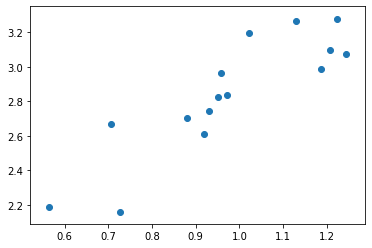

In [30]:
# Compute means and variance of each column
# x = np.mean(np.sqrt(AMR_rw.fillna(0)+1))
# y = np.var(np.sqrt(AMR_rw.fillna(0)+1))

x = np.mean(np.log(OTU_rw.fillna(0)+1))
y = np.var(np.log(OTU_rw.fillna(0)+1))

plt.scatter(x,y)

# The log transformation is better at reducing the mean-variance relationship. 
# https://en.wikipedia.org/wiki/Variance-stabilizing_transformation